In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image
import scipy
import os
import random
import shutil

In [2]:
# image_folder = "D:/Research/Oral Cancer Detection/Data/Mendeley Data/100x dataset V_2"

train_folder = "D:/Research/Oral Cancer Detection/Data/Mendeley Data/100x_Split_dataset_v2/train"
test_folder = "D:/Research/Oral Cancer Detection/Data/Mendeley Data/100x_Split_dataset_v2/test"
validation_folder = "D:/Research/Oral Cancer Detection/Data/Mendeley Data/100x_Split_dataset_v2/validate"

#------How i have splited the folder is defined here ::
# train_ratio = 0.7
# test_ratio = 0.15
# validation_ratio = 0.15

# os.makedirs(train_folder, exist_ok=True)
# os.makedirs(test_folder, exist_ok=True)
# os.makedirs(validation_folder, exist_ok=True)

# image_filenames = os.listdir(image_folder)

# random.shuffle(image_filenames)

# num_images = len(image_filenames)
# num_train = int(num_images * train_ratio)
# num_test = int(num_images * test_ratio)
# num_validation = num_images - num_train - num_test

# train_images = image_filenames[:num_train]
# test_images = image_filenames[num_train:num_train + num_test]
# validation_images = image_filenames[num_train + num_test:]

# for image_filename in train_images:
#     shutil.move(os.path.join(image_folder, image_filename), train_folder)

# for image_filename in test_images:
#     shutil.move(os.path.join(image_folder, image_filename), test_folder)

# for image_filename in validation_images:
#     shutil.move(os.path.join(image_folder, image_filename), validation_folder)


# print("Train set size:", len(train_images))
# print("Test set size:", len(test_images))
# print("Validation set size:", len(validation_images))

In [3]:
train_folder

'D:/Research/Oral Cancer Detection/Data/Mendeley Data/100x_Split_dataset_v2/train'

In [4]:
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)
validation_datagen= image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)
test_datagen= image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

In [5]:
train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary')
validation_generator = validation_datagen.flow_from_directory(
    validation_folder,
    target_size = (224,224),
    batch_size = 32,
    shuffle=True,
    class_mode = 'binary')
test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary')

Found 480 images belonging to 2 classes.
Found 149 images belonging to 2 classes.
Found 133 images belonging to 2 classes.


In [6]:
train_generator.class_indices

{'Normal': 0, 'OSCC': 1}

In [7]:
base_for_model = tf.keras.applications.VGG16(weights='imagenet', input_shape=(224,224,3), include_top=False)

ImportError: `load_weights` requires h5py package when loading weights from HDF5. Try installing h5py.

In [31]:
for layer in base_for_model.layers:
    layer.trainable = False

In [32]:
model = Sequential()
model.add(base_for_model) 
model.add(GaussianNoise(0.25)) #to prevent overfitting
model.add(GlobalAveragePooling2D()) #to converge and reduce the parameters
model.add(Dense(512, activation = 'relu')) #hidden layer (relu activation function is suggested for images)
model.add(BatchNormalization()) #to prevent overfitting
model.add(Dense(1, activation='sigmoid')) #output layer
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 gaussian_noise (GaussianNoi  (None, 7, 7, 512)        0         
 se)                                                             
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                        

In [33]:
adam= tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam,loss= 'binary_crossentropy', metrics=['accuracy','Precision','Recall','AUC'])

In [34]:
mp= tf.keras.callbacks.ModelCheckpoint(filepath='vgg16.hdf5',verbose=2, save_best_only=True)
es= tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.05, patience=3)
callback=[es,mp]

In [35]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1544222410690663112
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3608215552
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17673417936151553242
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [36]:
print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [37]:
history = model.fit(
    train_generator,
#     steps_per_epoch= 4946/32,
    epochs = 10, #own choice
    validation_data = validation_generator,
    callbacks=callback
)

Epoch 1/10
15/15 [==============================] - ETA: 0s - loss: 0.8049 - accuracy: 0.6062 - precision: 0.8819 - recall: 0.6035 - auc: 0.6926
Epoch 1: val_loss improved from inf to 2.97097, saving model to vgg16.hdf5
15/15 [==============================] - 37s 2s/step - loss: 0.8049 - accuracy: 0.6062 - precision: 0.8819 - recall: 0.6035 - auc: 0.6926 - val_loss: 2.9710 - val_accuracy: 0.2416 - val_precision: 1.0000 - val_recall: 0.0887 - val_auc: 0.8027
Epoch 2/10
15/15 [==============================] - ETA: 0s - loss: 0.4774 - accuracy: 0.7875 - precision: 0.9682 - recall: 0.7677 - auc: 0.8849
Epoch 2: val_loss did not improve from 2.97097
15/15 [==============================] - 21s 1s/step - loss: 0.4774 - accuracy: 0.7875 - precision: 0.9682 - recall: 0.7677 - auc: 0.8849 - val_loss: 3.2748 - val_accuracy: 0.2215 - val_precision: 1.0000 - val_recall: 0.0645 - val_auc: 0.8353
Epoch 3/10
15/15 [==============================] - ETA: 0s - loss: 0.3755 - accuracy: 0.8313 - precis

In [38]:
print(history.history.keys())
acc=(history.history['accuracy'])
loss=(history.history['loss'])
prc=(history.history['precision'])
rec=(history.history['recall'])
auc=(history.history['auc'])
val_acc=(history.history['val_accuracy'])
val_loss=(history.history['val_loss'])
val_prc=(history.history['val_precision'])
val_rec=(history.history['val_recall'])
val_auc=(history.history['val_auc'])

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


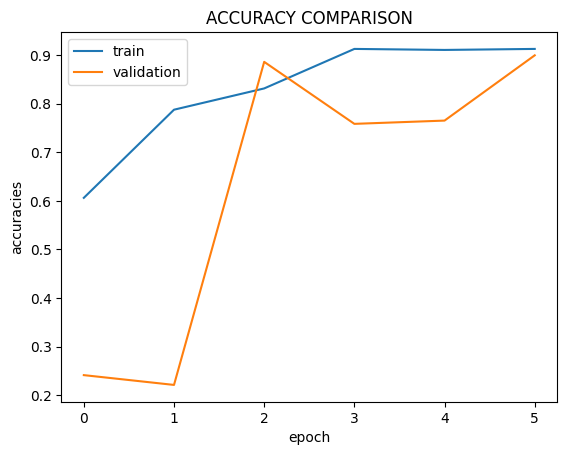

In [39]:
plt.plot(acc)
plt.plot(val_acc)
plt.title('ACCURACY COMPARISON')
plt.xlabel('epoch')
plt.ylabel('accuracies')
plt.title('ACCURACY COMPARISON')
plt.legend(['test','validation'])

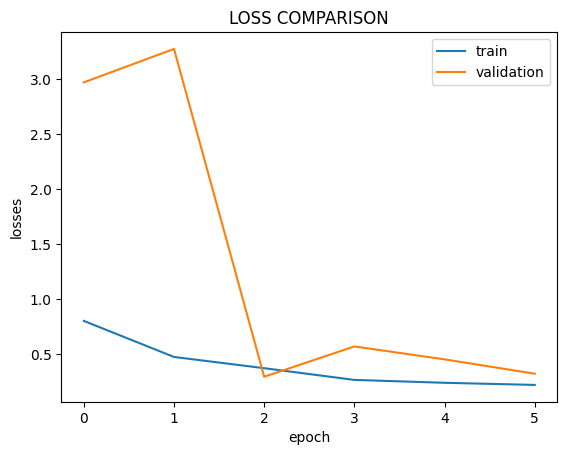

In [40]:
plt.title('LOSS COMPARISON')
plt.plot(loss)
plt.plot(val_loss)
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['test','validation'])

In [41]:
print("Model Train Evaluation")
model.evaluate(train_generator)
print("Model Validation Evaluation")
model.evaluate(validation_generator)
print("Model Test Evaluation")
model.evaluate(test_generator)

Model Train Evaluation
15/15 [==============================] - 15s 1s/step - loss: 0.2656 - accuracy: 0.9021 - precision: 0.9888 - recall: 0.8914 - auc: 0.9795
Model Validation Evaluation
5/5 [==============================] - 5s 909ms/step - loss: 0.2598 - accuracy: 0.8993 - precision: 0.9823 - recall: 0.8952 - auc: 0.9758
Model Test Evaluation
5/5 [==============================] - 6s 1s/step - loss: 0.2733 - accuracy: 0.9173 - precision: 1.0000 - recall: 0.9076 - auc: 0.9874


[0.27328813076019287,
 0.9172932505607605,
 1.0,
 0.9075630307197571,
 0.9873949289321899]

In [42]:
test_metrics = model.evaluate(test_generator)
test_loss = test_metrics[0]
test_accuracy = test_metrics[1]
test_precision = test_metrics[2]
test_recall = test_metrics[3]
test_auc = test_metrics[4]

5/5 [==============================] - 4s 740ms/step - loss: 0.2694 - accuracy: 0.9098 - precision: 0.9908 - recall: 0.9076 - auc: 0.9676


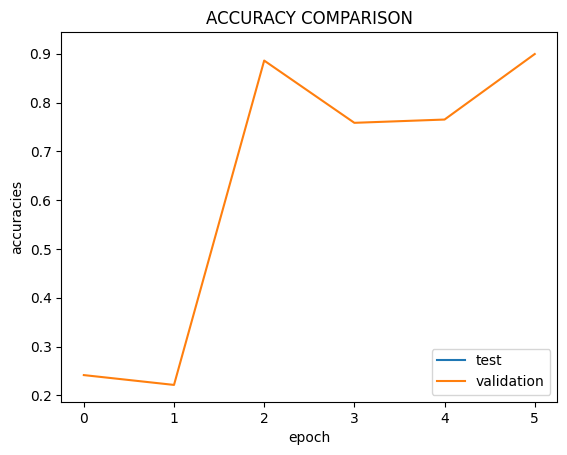

In [43]:
plt.plot(test_accuracy)
plt.plot(val_acc)
plt.title('ACCURACY COMPARISON')
plt.xlabel('epoch')
plt.ylabel('accuracies')
plt.title('ACCURACY COMPARISON')
plt.legend(['test','validation'])

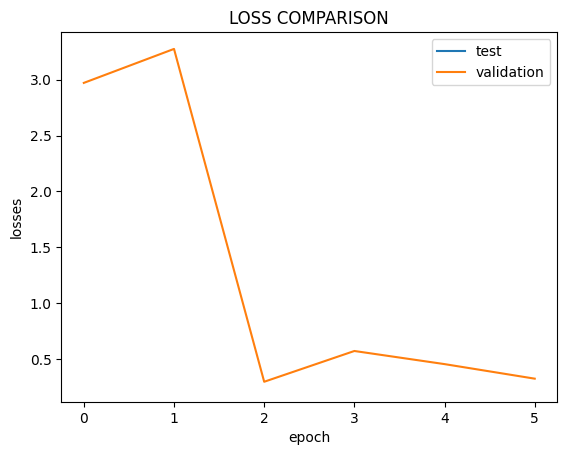

In [44]:
plt.title('LOSS COMPARISON')
plt.plot(test_loss)
plt.plot(val_loss)
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['test','validation'])

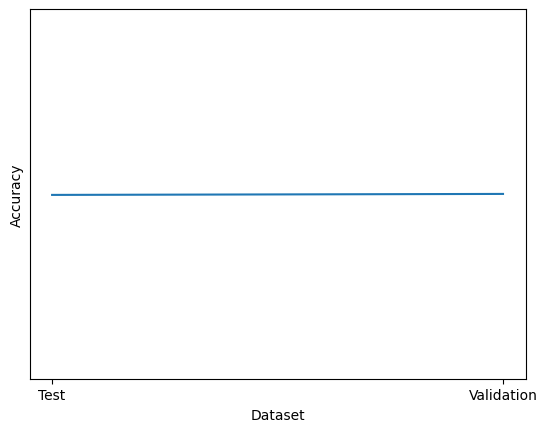

In [45]:
test_accuracy = 0.8492
val_accuracy = 0.8500
accuracy_scores = [test_accuracy, val_accuracy]
x_labels = ['Test', 'Validation']

plt.plot(x_labels, accuracy_scores)
plt.plot('Accuracy Comparison')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.ylim([0.7, 1])
plt.show()

1/1 [==============================] - 1s 744ms/step


'Normal'

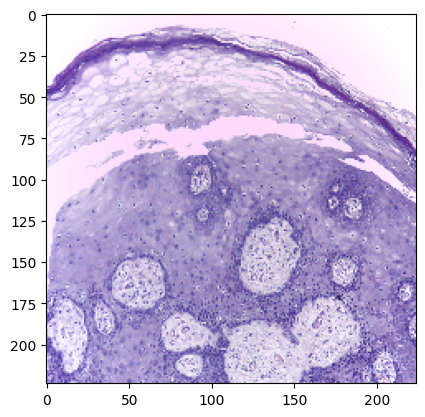

In [46]:
img =(image.load_img('D:/Research/Oral Cancer Detection/Data/Mendeley Data/First Set/100x Normal Oral Cavity Histopathological Images/Normal_100x_12.jpg',target_size=(224,224)))
imaga = image.img_to_array(img)
image = np.expand_dims(imaga,axis=0)  
ypred = model.predict(image)
if ypred<0.5:
      ypred="Normal"
else:
      ypred="Squamous Cell Carcinoma" 
plt.imshow(img)
ypred

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
predictions = model.predict(test_generator)
test_generator.classes
cm = confusion_matrix(test_generator.classes, predictions.round())

sns.heatmap(cm,  annot=True, fmt="d" ,cmap="YlGnBu")

ModuleNotFoundError: No module named 'seaborn'

In [23]:
from sklearn.metrics import classification_report
print(classification_report(test_generator.classes, predictions.round())) #.argmax(axis=-1)

ModuleNotFoundError: No module named 'sklearn'

In [47]:
model.save("vgg16.h5")
print("Saved model to disk")

Saved model to disk


In [2]:
model=tf.keras.models.load_model('vgg16.h5')